In [34]:
# Import Packages
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
torch.manual_seed(0)

In [41]:
# Plotting channels of CNN (kernels)
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index = 0
    in_index = 0
    for ax in axes.flat:
        if in_index > n_in - 1:
            out_index += 1
            in_index = 0
        
        ax.imshow(W[out_index, in_index, :, :], vmin = w_min, vmax = w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index += 1
    plt.show()

In [23]:
# Show images with permutated shape
def show(data, label, shape):
    plt.imshow(data.reshape(shape), cmap = 'gray')
    plt.title('y = ' + str(label))
    plt.colorbar()
    plt.show()

In [76]:
class Data(Dataset):
    def __init__(self, N_images, offset=0, p=0.9, train=True):
        if train:
            torch.manual_seed(1)
            
        N_images = 2 * (N_images // 2)
        images = np.zeros((N_images, 1, 11, 11))
        start1 = 3
        start2 = 1
        self.y = torch.zeros(N_images).type(torch.long)
        
        for n in range(N_images):
            if offset > 0:
                low = int(np.random.randint(low=start1, high=start1 + offset, size=1))
                high = int(np.random.randint(low=start2, high=start2+offset, size=1))
            else:
                low = 4
                high = 1
                
            if n <= N_images // 2:
                self.y[n] = 0
                images[n, 0, high:high+9, low:low+3] = np.random.binomial(1, p, (9, 3))
            else:
                self.y[n] = 1
                images[n, 0, low:low+3, high:high+9] = np.random.binomial(1, p, (3, 9))
                
        self.x = torch.from_numpy(images).type(torch.FloatTensor)
        self.len = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [77]:
def conv_shape(h_w, kernel_size=2, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor(((h_w[0] + (2 * pad) - (dilation * (kernel_size[0] - 1)) - 1) / stride) + 1)
    w = floor(((h_w[1] + (2 * pad) - (dilation * (kernel_size[1] - 1)) - 1) / stride) + 1)
    return h, w

In [78]:
train_ds = Data(10000)
val_ds = Data(1000, train=False)

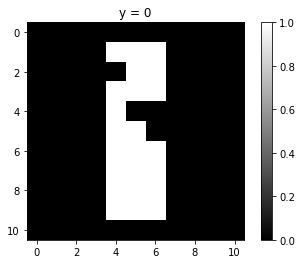

In [79]:
show(train_ds[0][0].numpy(), train_ds[0][1].numpy(), shape=(11, 11))

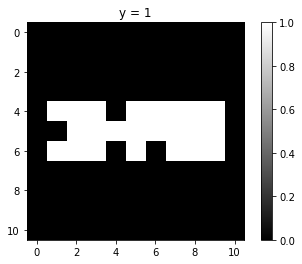

In [80]:
show(train_ds[9000][0].numpy(), train_ds[9000][1].numpy(), shape=(11, 11))

In [81]:
# Shapes as they change between layers
shapes = []
shapes.append(conv_shape((11, 11)))
for i in range(3):
    shapes.append(conv_shape(shapes[i]))
    
for i, shape in enumerate(shapes):
    print(f'Shape {i + 1}: {shape}')

Shape 1: (10, 10)
Shape 2: (9, 9)
Shape 3: (8, 8)
Shape 4: (7, 7)


In [82]:
class CNN(nn.Module):
    def __init__(self, out_1=2, out_2=1, act_func=torch.relu):
        super(CNN, self).__init__()
        self.act_func = act_func # Default ReLU
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(out_1, out_2, 2)
        self.maxpool2 = nn.MaxPool2d(2, stride=1)
        self.lin1 = nn.Linear(out_2 * 7 * 7, 2) # input is reshaped to a tensor of shape (out_2 * 7 * 7, 1)
    def forward(self, x):
        x = self.act_func(self.conv1(x))
        x = self.maxpool1(x)
        x = self.act_func(self.conv2(x))
        x = self.maxpool2(x)
        x = self.lin1(x.view(x.size(0), -1))
        return x

In [92]:
model = CNN(2, 1) # Default
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.1665,  0.0592],
                        [-0.1172,  0.1587]]],
              
              
                      [[[-0.2430,  0.4746],
                        [ 0.1412, -0.3287]]]])),
             ('conv1.bias', tensor([ 0.1377, -0.0463])),
             ('conv2.weight',
              tensor([[[[-0.2488,  0.2577],
                        [ 0.1942,  0.2366]],
              
                       [[-0.2973, -0.3090],
                        [-0.0484,  0.3247]]]])),
             ('conv2.bias', tensor([-0.1258])),
             ('lin1.weight',
              tensor([[ 0.1002,  0.1322,  0.0652, -0.1391, -0.0100,  0.0787, -0.0425,  0.0440,
                       -0.0910,  0.0175, -0.1278, -0.0715, -0.0769, -0.0173, -0.0227,  0.0656,
                       -0.0734, -0.1125, -0.1072,  0.1286,  0.1229, -0.1320,  0.1009, -0.0693,
                        0.0216, -0.0620,  0.0574,  0.0377, -0.0008, -0.0793,  0.0972, -0.1250,
                

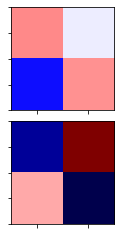

In [93]:
plot_channels(model.state_dict()['conv1.weight'])

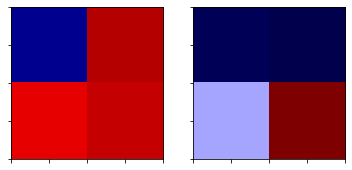

In [94]:
plot_channels(model.state_dict()['conv2.weight']) # Highly negative on the 2nd kernel channel (The two channels represent the 3d config of it)

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
train_loader = DataLoader(train_ds, batch_size=30, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=10, shuffle=True)

In [97]:
def train(model, optimizer, train_loader, val_loader, criterion, epochs):
    results = {'training loss': [], 'val accuracy': []}
    for epoch in range(epochs):
        epoch_cost = 0
        for x, y in train_loader:
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_cost += loss.item()
        results['training loss'].append(epoch_cost)
        
        correct = 0
        for x, y in val_loader:
            y_hat = model(x)
            _, label = torch.max(y_hat.data, 1)
            correct += (y == label).sum().item()
        results['val accuracy'].append(correct / len(val_loader.dataset))
        print(epoch, end=' ')
    return results

In [98]:
results = train(model, optimizer, train_loader, val_loader, criterion, 10)

0 1 2 3 4 5 6 7 8 9 

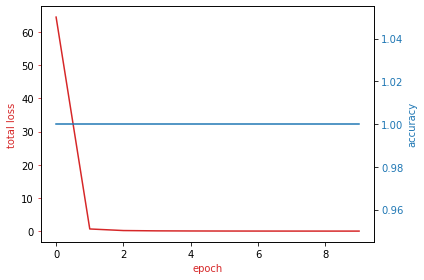

In [99]:
# Really easy prediction so the accuracy was perfect after one epoch of training
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(results['training loss'],color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(results['val accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

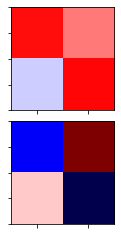

In [101]:
plot_channels(model.state_dict()['conv1.weight'])

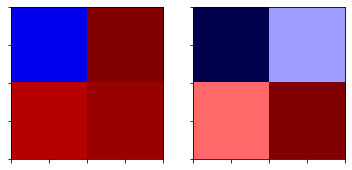

In [102]:
plot_channels(model.state_dict()['conv2.weight'])